In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import *
from features import *
from stats import *
from preprocess import *
from model import *
from step import Step
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint
import lightning as L
import matplotlib.pyplot as plt

In [27]:
step = Step(load_mnm_spatial)
step = Step(gt_n_trials, step, n=8)
# step = Step(subset, step, key='monkey', value='NIN')
# step = Step(subset, step, key='subregion', value='AD')
# step = Step(subset, step, key='cell', value='NIN-PFC-AD-PRE-145')
# step = Step(win_cts_by_trial, step, win_start=1500, win_end=5000, win_size=500, win_stride=500)
# step = Step(win_cts_by_win, step)
step = Step(win_cts_by_trial, step, win_start=1500, win_end=5000, win_size=500, win_stride=500)
step = Step(win_cts_by_win, step)
# step = Step(select, step, wins=[7, 17, 18, 21, 22, 23, 37, 43])
step = Step(stat_tests, step)
# step = Step(sig_stat, step, stat='anova_p', alpha=0.03, keep_win=True)
# step = Step(select, step)
# step = Step(tvt_split, step, num_splits=10, num_val=1, num_test=1)
# step = Step(gen_samples, step, num_train=120, num_val=1, num_test=1)


In [31]:
sbcw = step()['stats_by_cell_win']
sbcw[sbcw.anova_p < 1e-4].groupby('cell').size()

cell
ADR-PFC-PD-POST-1834    1
ADR-PFC-PD-POST-1835    2
ADR-PFC-PD-POST-1864    2
ADR-PFC-PD-POST-1865    4
ADR-PFC-PD-POST-1910    1
                       ..
MAN-PFC-PD-PRE-1194     1
MAN-PFC-PD-PRE-1195     2
NIN-PFC-AD-PRE-145      1
NIN-PFC-MD-PRE-1034     1
SCR-PFC-PD-PRE-1224     1
Length: 144, dtype: int64

In [30]:
raw_df = step()['raw_df']
raw_df.loc['ADR-PFC-MD-POST-1942']

KeyError: 'ADR-PFC-MD-POST-1942'

In [88]:
data = step()

In [89]:
wins_anovap_03 = [7, 9, 10, 13, 17, 18, 21, 22, 23, 37, 43]

In [93]:
wcbt = data['win_cts_by_trial']
wcbt

ismatch  \
cell               position trial            
NIN-PFC-AD-PRE-145 0        0            0   
                            1            0   
                            2            1   
                            3            1   
                            4            0   
...                                    ...   
                   7        25           1   
                            26           1   
                            27           1   
                            28           0   
                            29           0   

                                                                             win_cts  
cell               position trial                                                     
NIN-PFC-AD-PRE-145 0        0      [2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, ...  
                            1      [3.0, 3.0, 3.0, 1.0, 2.0, 1.0, 3.0, 0.0, 1.0, ...  
                            2      [3.0, 1.0, 5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  
                            3      [4.0, 6.0, 3.0, 4.0, 1.0, 4.0, 0.0, 1.0, 2.0, ...  
                            4      [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...  
...                                                                              ...  
                   7        25     [2.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, 0.0, ...  
                            26     [0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...  
                            27     [0.0, 0.0, 1.0, 1.0, 1.0, 5.0, 0.0, 2.0, 2.0, ...  
                            28     [2.0, 3.0, 0.0, 3.0, 2.0, 2.0, 2.0, 4.0, 10.0,...  
                            29     [3.0, 0.0, 1.0, 5.0, 16.0, 2.0, 0.0, 1.0, 1.0,...  

[247 rows x 2 columns]

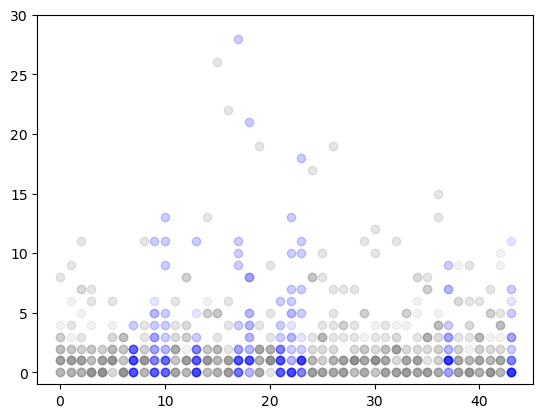

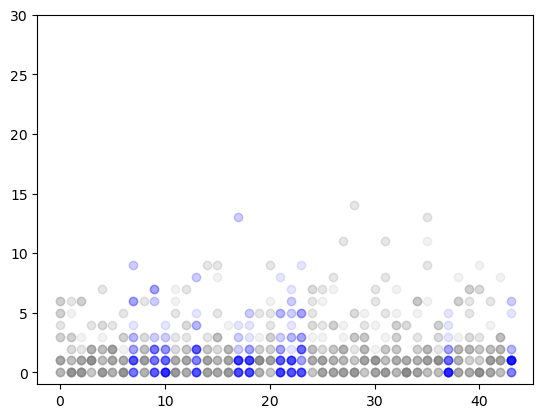

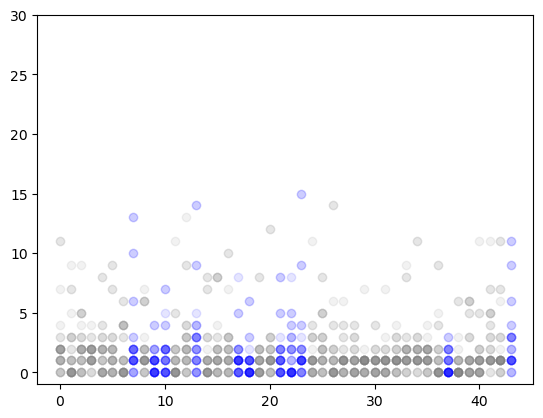

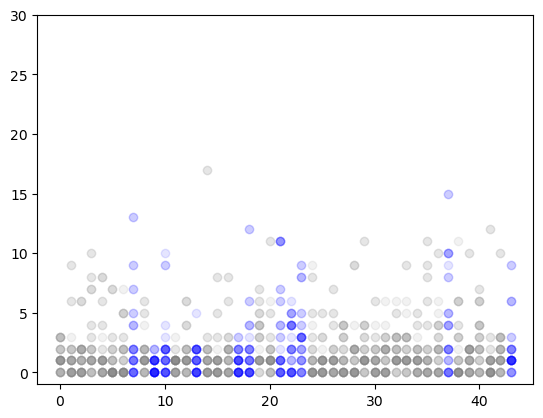

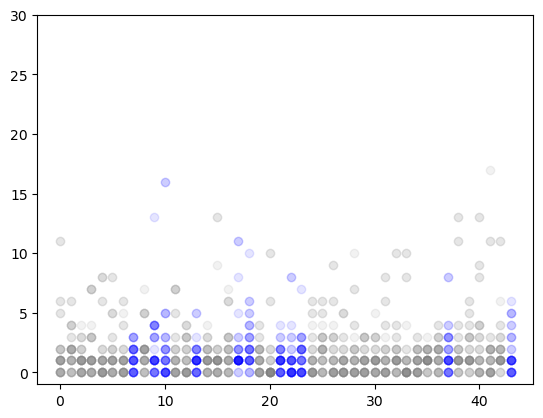

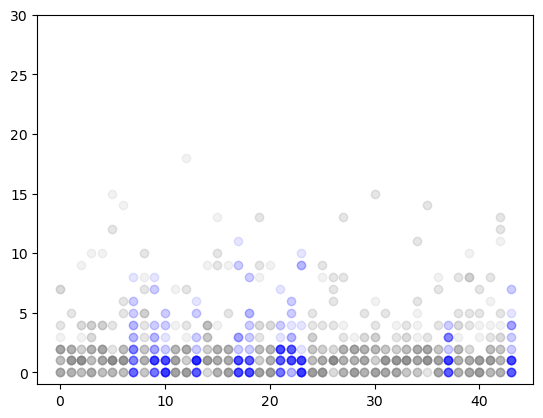

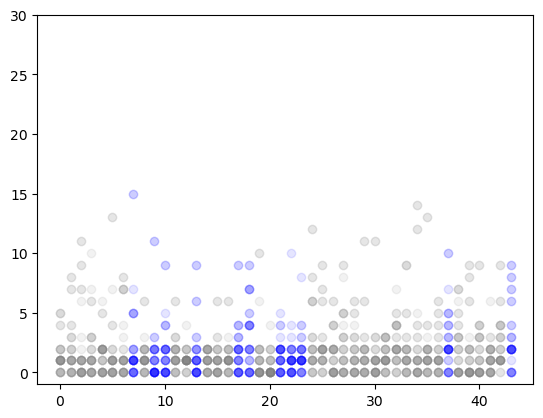

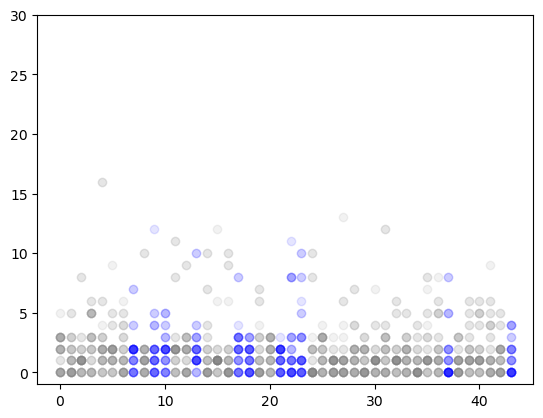

In [124]:
for p in range(8):
    w = wcbt.loc['NIN-PFC-AD-PRE-145', p].win_cts
    for j in range(len(w)):
        w0 = w[j]
        special = [w0[i] for i in range(len(w0)) if i in wins_anovap_03]
        not_special = [w0[i] for i in range(len(w0)) if i not in wins_anovap_03]
        wins_not_anovap_03 = [i for i in range(len(w0)) if i not in wins_anovap_03]
        plt.scatter(wins_anovap_03, special, color='blue', alpha=0.1)
        plt.scatter(wins_not_anovap_03, not_special, color='gray', alpha=0.1)
    plt.ylim(-1, 30)
    plt.show()

In [58]:
import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
logging.getLogger("pytorch_lightning.utilities").setLevel(logging.ERROR)

def train(i, drop_cols=None):
    callback = ModelCheckpoint(save_top_k=1, monitor='val_acc', mode='max')
    # mlflow.pytorch.autolog(checkpoint_monitor='val_acc', checkpoint_mode='max')

    train, val, test = data['train'][i], data['val'][i], data['test'][i]
    if drop_cols:
        cols_to_keep = [i for i in range(train.shape[1]) if i not in drop_cols]
        train = train.clone()[:, cols_to_keep]
        val = val.clone()[:, cols_to_keep]
        test = test.clone()[:, cols_to_keep]

    data_module = DataModule(*[train, val, test], one_hot_max=0.85, train_batch_size=7)
    input_size = data_module.train_dataloader().dataset[0][0].shape[0]
    model = CrossEntropyFNN(input_size, [2**10] * 4, 8)

    trainer = L.Trainer(max_epochs=10, callbacks=[callback], enable_progress_bar=False)
    trainer.fit(model, data_module)
    train_acc = trainer.logged_metrics['best_train_acc']
    val_acc = trainer.logged_metrics['best_val_acc']
    model = CrossEntropyFNN.load_from_checkpoint(callback.best_model_path)
    test_results = trainer.test(model, data_module, verbose=False) #, ckpt_path="best")

    return model, trainer, data_module, val_acc, test_results[0]['test_acc']

In [77]:
test_accs = []
val_accs = []
for s in range(10):
    model, trainer, data_module, val_acc, test_acc = train(s)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
    print(val_acc, test_acc)
print(np.mean(val_accs), np.mean(test_accs))

tensor(0.7500) 0.75
tensor(0.8750) 0.875
tensor(1.) 0.75
tensor(1.) 1.0
tensor(0.8750) 0.625
tensor(0.7500) 0.625
tensor(0.7500) 0.75
tensor(0.7500) 0.875
tensor(0.8750) 0.625
tensor(0.7500) 0.875
0.8375 0.775


In [74]:
test_accs = []
val_accs = []
for s in range(10):
    model, trainer, data_module, val_acc, test_acc = train(s)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
    print(val_acc, test_acc)
print(np.mean(val_accs), np.mean(test_accs))

tensor(0.7500) 0.75
tensor(0.7500) 0.75
tensor(0.8750) 0.625
tensor(0.7500) 0.625
tensor(1.) 0.75
tensor(0.8750) 0.75
tensor(0.8750) 0.5
tensor(0.7500) 0.625
tensor(0.8750) 1.0
tensor(0.6250) 0.5
0.8125 0.6875


In [59]:
test_accs = []
val_accs = []
for s in range(10):
    model, trainer, data_module, val_acc, test_acc = train(s)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
print('',  np.mean(val_accs), np.mean(test_accs))

for d in range(11):
    if d in [1]: continue
    test_accs = []
    val_accs = []
    for s in range(10):
        model, trainer, data_module, val_acc, test_acc = train(s, drop_cols=[1, d])
        test_accs.append(test_acc)
        val_accs.append(val_acc)
    print([1, d],  np.mean(val_accs), np.mean(test_accs))

 0.8125 0.7125
0 0.8375 0.7375
1 0.85 0.775
2 0.8375 0.7625
3 0.85 0.775
4 0.85 0.75
5 0.85 0.75
6 0.85 0.7125
7 0.8375 0.6875
8 0.8 0.725
9 0.825 0.7
10 0.825 0.7125


In [62]:
test_accs = []
val_accs = []
for s in range(10):
    model, trainer, data_module, val_acc, test_acc = train(s, drop_cols=[1, 2, 3])
    test_accs.append(test_acc)
    val_accs.append(val_acc)
print(np.mean(val_accs), np.mean(test_accs))

0.7875 0.7625


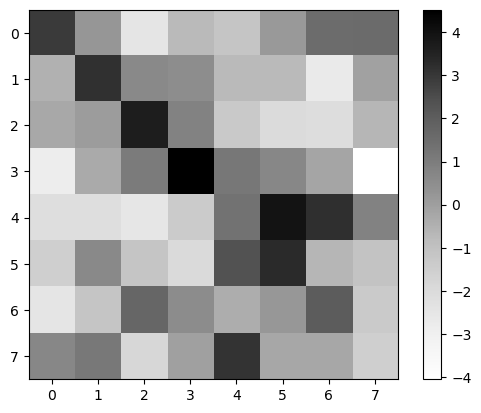

In [51]:
output = model(data_module.test_dataloader().dataset[:][0])
plt.imshow(output.detach().numpy(), cmap='Greys')
plt.colorbar()

In [38]:
torch.sum(model.layers[0].weight, dim=0)

tensor([  7.4948,  -7.0217,  -5.7720,  -1.1671,  -4.9420,  -3.2121, -11.5318,
         -1.1171,  -4.0063,  -1.2483,   7.7161], grad_fn=<SumBackward1>)

In [26]:
step()['stats_by_cell_win']

t_p  \
cell               win                                                      
NIN-PFC-AD-PRE-145 7    [0.024920216287411586, 0.684451346644656, 0.07...   
                   9    [0.03876383804654577, 0.22208909356434303, 0.0...   
                   10   [0.001086816067606481, 0.027421264425379423, 0...   
                   13   [0.8882967269916724, 0.9172803267634977, 0.000...   
                   17   [1.4465282312172164e-05, 0.532424140191016, 0....   
                   18   [6.310746228224382e-05, 0.046995203687315405, ...   
                   21   [0.7034009764963027, 0.5743341172254712, 0.961...   
                   22   [0.0005054310358205952, 0.5853102638968695, 0....   
                   23   [0.00356378637520579, 0.46780213172109986, 0.5...   
                   37   [0.29040434028334733, 0.010081443011236646, 0....   
                   43   [0.895817960871442, 0.06902184206556539, 0.010...   

                             min_t_p  min_t_p_pos       anova_p  kruskal_p  
cell               win                                                      
NIN-PFC-AD-PRE-145 7    2.492022e-02            0  2.847476e-02   0.233867  
                   9    3.348365e-03            3  1.300957e-02   0.003544  
                   10   1.086816e-03            0  1.616625e-02   0.064868  
                   13   3.122165e-04            2  9.400116e-03   0.014605  
                   17   1.446528e-05            0  2.589732e-03   0.034263  
                   18   6.310746e-05            0  8.683973e-05   0.000089  
                   21   4.572028e-07            3  3.302509e-04   0.597859  
                   22   5.054310e-04            0  1.615787e-02   0.081176  
                   23   3.563786e-03            0  2.620317e-02   0.072482  
                   37   2.751330e-08            3  3.653791e-08   0.000005  
                   43   4.306306e-03            6  4.355815e-03   0.008889

In [44]:
step()['win_cts_by_trial']

win_cts
cell               position trial                                        
NIN-PFC-AD-PRE-145 0        0         [4.0, 4.0, 6.0, 5.0, 4.0, 9.0, 9.0]
                            1        [4.0, 12.0, 4.0, 2.0, 4.0, 3.0, 4.0]
                            2         [2.0, 5.0, 2.0, 3.0, 3.0, 6.0, 1.0]
                            3         [6.0, 9.0, 6.0, 8.0, 2.0, 3.0, 3.0]
                            4         [7.0, 2.0, 5.0, 5.0, 8.0, 6.0, 8.0]
...                                                                   ...
                   7        25        [3.0, 2.0, 2.0, 4.0, 1.0, 2.0, 5.0]
                            26     [3.0, 5.0, 5.0, 16.0, 12.0, 7.0, 12.0]
                            27      [7.0, 14.0, 8.0, 10.0, 3.0, 4.0, 4.0]
                            28     [20.0, 10.0, 7.0, 7.0, 10.0, 5.0, 7.0]
                            29      [14.0, 7.0, 6.0, 9.0, 4.0, 15.0, 3.0]

[247 rows x 1 columns]

In [29]:
# for w in range(0, 7):
#     step()['win_cts'].loc['NIN-PFC-AD-PRE-145', :, :, w].boxplot(by='position', column='win_cts')

(0.0, 30.0)

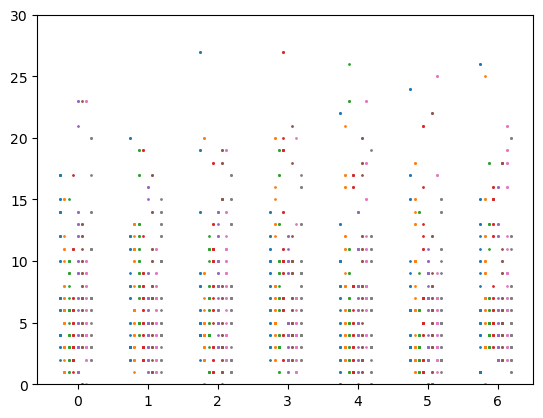

In [42]:
for p in range(8):
    cts = np.stack(step()['win_cts_by_trial'].loc['NIN-PFC-AD-PRE-145', p].win_cts.array)
    x = np.tile(np.arange(cts.shape[1]), cts.shape[0])
    y = cts.flatten()
    plt.scatter(x - 0.25 + 0.5 * p / 8, y, s=1)
    # plt.plot(np.mean(cts, axis=0))
    # plt.show()
plt.ylim(0, 30)